In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


This data corresponds to a set of financial transactions associated with individuals. The data has been standardized, de-trended, and anonymized. You are provided with over two hundred thousand observations and nearly 800 features. Each observation is independent from the previous.

For each observation, it was recorded whether a default was triggered. In case of a default, the loss was measured. This quantity lies between 0 and 100. It has been normalised, considering that the notional of each transaction at inception is 100. For example, a loss of 60 means that only 40 is reimbursed. If the loan did not default, the loss was 0. You are asked to predict the losses for each observation in the test set.

Missing feature values have been kept as is, so that the competing teams can really use the maximum data available, implementing a strategy to fill the gaps if desired. Note that some variables may be categorical (e.g. f776 and f777).

The competition sponsor has worked to remove time-dimensionality from the data. However, the observations are still listed in order from old to new in the training set. In the test set they are in random order.

The first factor is determining the probability of a borrower defaulting on a loan, while the second factor involves evaluating the financial impact on the lender in case of such a default.

If you want to know more about credit risk modelling, see : https://finbox.in/blog/credit-risk-modelling/

# Importing all necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, mutual_info_score, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv


# Data Exploration and Preprocessing

In [3]:
# load the data
df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")
df.head(9)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2


In [4]:
# shape of the data
df.shape

(32581, 12)

In [5]:
# type of each column
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [6]:
# unique values of each object column
for col in df.select_dtypes(include=['object']):
    print(col, ":" ,df[col].unique())

person_home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent : ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade : ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file : ['Y' 'N']


In [7]:
df_check = df.groupby('loan_grade').head(5)
df_check.shape

(35, 12)

In [8]:
# check loan grade is ordinal or not?
df.groupby('loan_grade').head(2).reset_index(drop=True).sort_values(by='loan_grade')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
5,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
7,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3
8,26,108160,RENT,4.0,EDUCATION,E,35000,18.39,1,0.32,N,4
10,25,137000,RENT,9.0,PERSONAL,E,34800,16.77,0,0.25,Y,2


In [9]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [10]:
len(df)

32581

In [11]:
# check for other missing value percentage
(df.isnull().sum() / len(df)).sort_values(ascending=False) * 100

loan_int_rate                 9.563856
person_emp_length             2.747000
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [12]:
# df.fillna('NA', inplace=True)
# df.loc[df['loan_int_rate']=='NA']

- As you can see there is a significant number of rows with missing values in the 'loan_int_rate' column, accounting for approximately **9.5%** of the dataset. Upon running the previous cell, you can see that *3116* rows lack information regarding the loan interest rate. 
---
- I believe that the loan interest rate is a crucial factor in predicting credit defaults. However, there is insufficient information within the existing dataset to impute these missing values, and the data description offers limited information. 
---
- Hence, I decided to remove rows with NaN values in the 'loan_int_rate' column. There is still a significant amount of data available even after these removals, allowing us to continue our analysis with a reasonably sized dataset.
---

In [13]:
# dropping the missing values
df.dropna(inplace=True)

In [14]:
df.shape

(28638, 12)

In [15]:
df['loan_status'].value_counts()

loan_status
0    22435
1     6203
Name: count, dtype: int64

In [16]:
df['loan_intent'].value_counts()

loan_intent
EDUCATION            5704
MEDICAL              5293
VENTURE              5001
PERSONAL             4877
DEBTCONSOLIDATION    4565
HOMEIMPROVEMENT      3198
Name: count, dtype: int64

In [17]:
fig = px.histogram(
    df, 
    x = 'loan_status',
    color='loan_intent',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Loan Status Distribution'
)
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


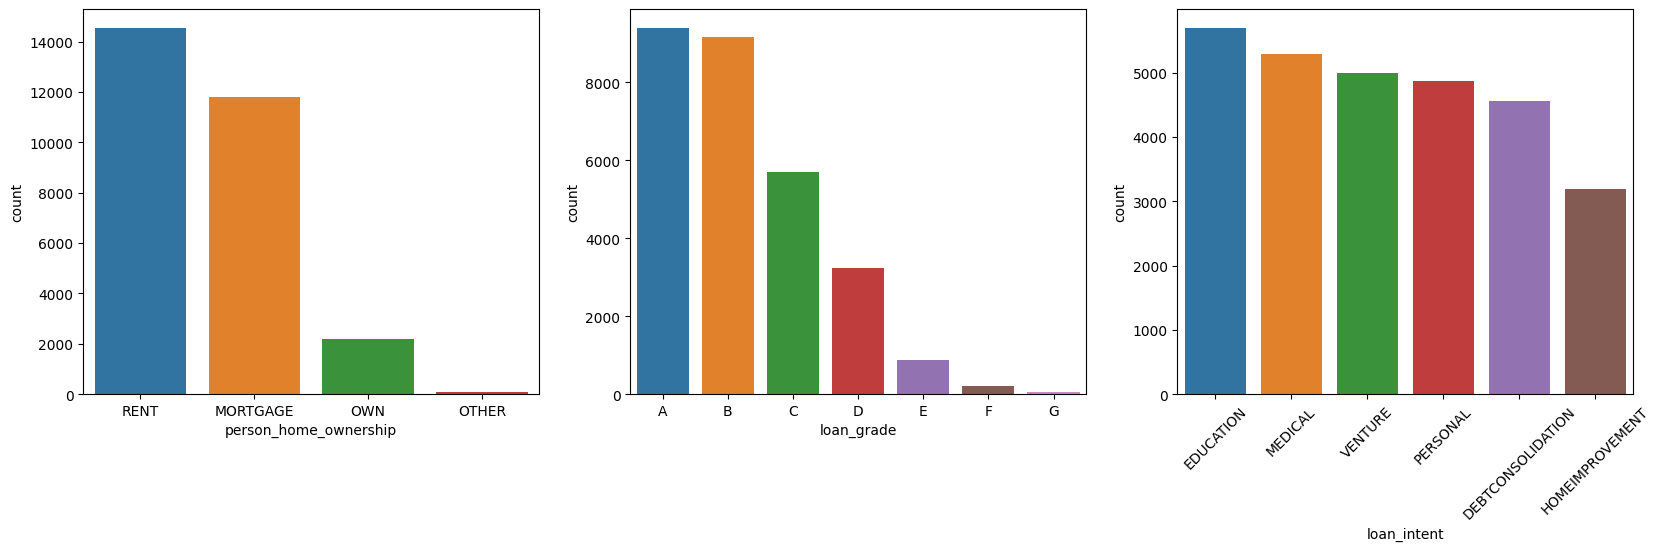

In [18]:
columns = {0:'person_home_ownership', 1: 'loan_grade', 2: 'loan_intent'}
fig, ax = plt.subplots(1,3, figsize=(20, 5))

for key, val in columns.items(): 
    sns.countplot(x=val,  data=df, ax=ax[key], order = df[val].value_counts().index)
    plt.xticks(rotation=45)

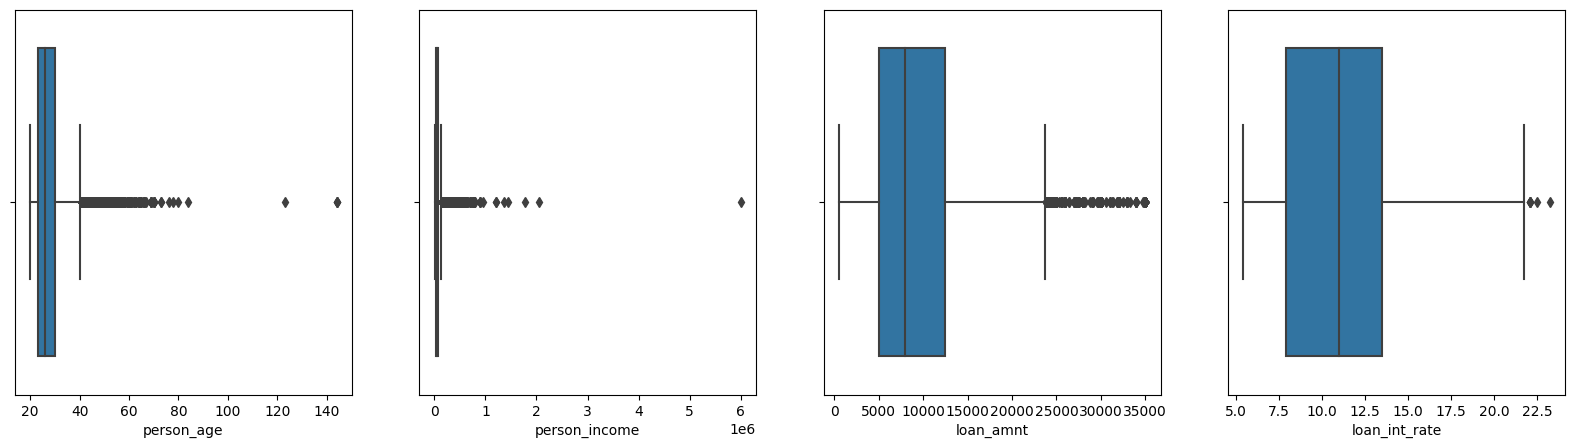

In [19]:
columns = {0:'person_age' , 1: 'person_income', 2: 'loan_amnt', 3:'loan_int_rate'}
fig, ax = plt.subplots(1,len(columns), figsize=(20, 5))
for key, val in columns.items(): 
    sns.boxplot(x=df[val], ax= ax[key])

In [20]:
fig = px.box(
    df,
    x = 'person_age',
    y = 'loan_amnt',
    facet_col= 'loan_intent',
    facet_col_wrap=2,
    color='loan_grade',
    height=700
)

fig.show()

In [21]:
y0 = np.random.randn(50)
y0

array([ 0.05359959, -0.31167581, -0.4519264 , -0.67609448, -0.6682229 ,
        1.70115102,  0.22677256, -0.08167915,  1.79479245,  0.05834078,
       -0.02474965, -0.46888682,  0.54493252,  1.61497529,  1.42259418,
       -1.98472088, -1.85242286,  1.25945771,  0.63079219, -1.11405213,
       -0.26403171, -0.31558962,  0.98216817, -0.20972345, -0.13105647,
       -0.08698857,  0.28999793,  1.05351675,  0.13811026,  0.13752751,
        0.40003006, -0.13655571,  0.21028739,  2.61583746, -1.31444444,
        0.83346214,  0.30783306, -0.90471302, -0.07456137, -1.39177845,
        0.05842017, -0.45701683, -0.0833114 ,  0.040352  ,  0.13405435,
       -1.03009174, -0.33537498, -2.04008742,  0.55713114,  2.17736128])

In [22]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [23]:
fig = go.Figure()
fig.add_trace(go.Box(y=df['loan_amnt'], name='Loan Amount',
                marker_color = 'indianred'))
fig.add_trace(go.Box(y=df['person_income'], name = 'Person income',
                marker_color = 'lightseagreen'))

fig.show()

In [24]:
max_index = df['person_income'].idxmax()

In [25]:
df = df.drop(max_index)

In [26]:
fig = go.Figure()
fig.add_trace(go.Box(y=df['loan_amnt'], name='Loan Amount',
                marker_color = 'indianred'))

fig.show()

In [27]:
fig = go.Figure()
fig.add_trace(go.Box(y=df['person_income'], name = 'Person income',
                marker_color = 'lightseagreen'))
fig.show()

In [28]:
6e6

6000000.0

In [29]:
# assuming a persons limit is less than 90 years old for loan eligibility 
df2 = df.loc[(df['person_age'] <= 90) &  (df['person_income'] < 6e6) ]

In [30]:
fig = px.histogram(
    df2, 
    x = 'person_age',
    # color='loan_intent',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Person Age Distribution'
)
fig.show()

In [31]:
df2.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [32]:
fig = px.scatter_matrix(df2,
    dimensions=["person_age", "loan_amnt", "person_income"],
    color="loan_status")
fig.show()

In [33]:
fig = px.scatter(df2, x="person_age", y="loan_amnt", color='loan_status')
fig.show()

- There is no significant patterns that explains the relationship between the age and loan amount according to the scatterplot. 

- Similar results were obtained for loand interest rate as well.

<Axes: xlabel='person_age', ylabel='loan_amnt'>

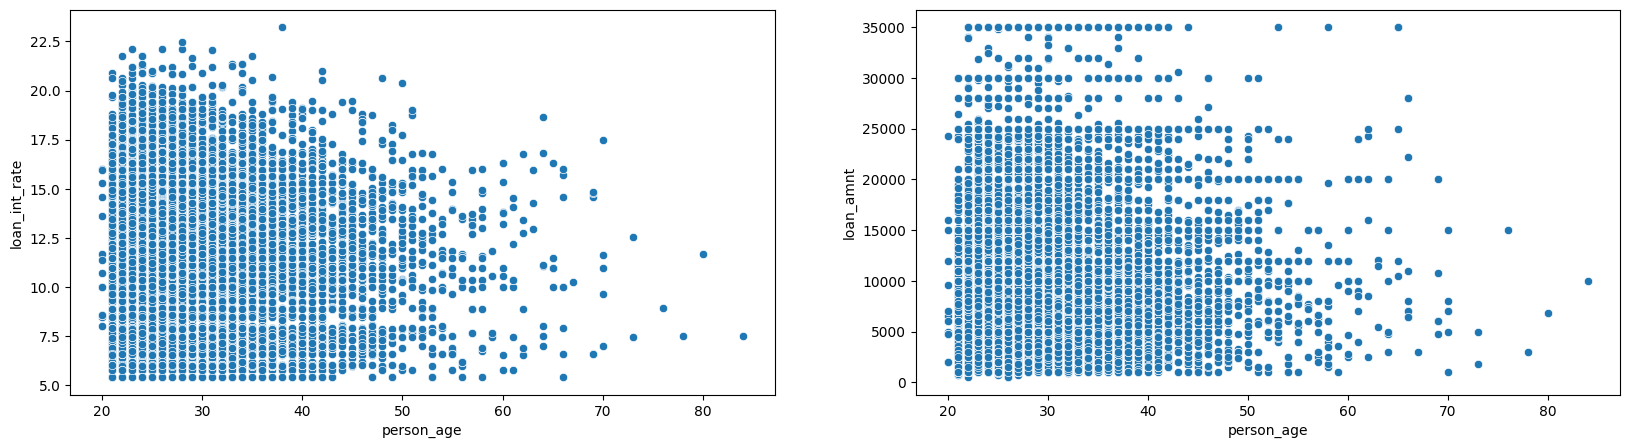

In [34]:
# age vs loan amount and loan rate
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.scatterplot(data=df2, x="person_age", y="loan_int_rate", ax=ax[0])
sns.scatterplot(data=df2, x="person_age", y="loan_amnt", ax=ax[1])

In [35]:
# Convert Yes and No values to 0 and 1
data_df=df2.copy()
data_df['cb_person_default_on_file']=data_df.cb_person_default_on_file.map(dict(Y=1, N=0))

In [36]:
data_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,0,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,1,4


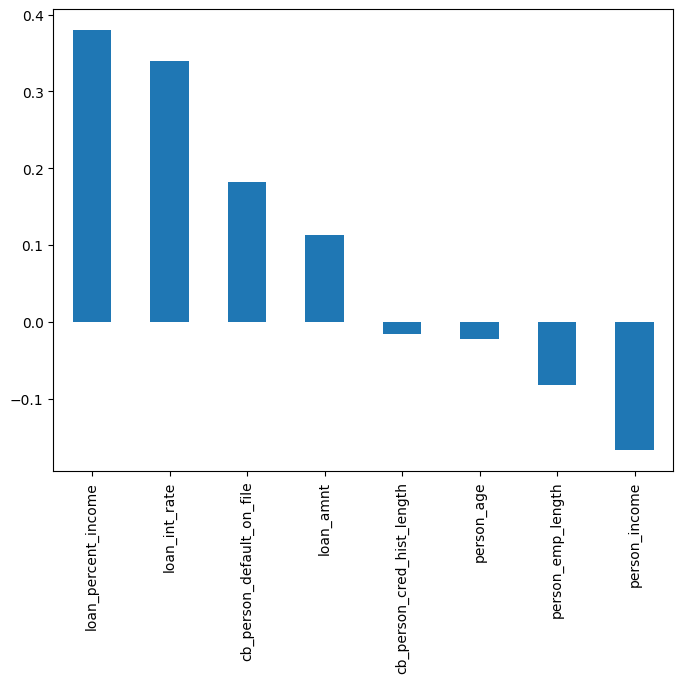

In [37]:
# check correlation between the target and the features
conti_df= data_df.select_dtypes(exclude=[object])

corr_with_tot_count = conti_df.corr()["loan_status"].sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr_with_tot_count.drop("loan_status").plot.bar()
plt.show()

In [38]:
conti_df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,123.0,35000,16.02,1,0.59,1,3
1,21,9600,5.0,1000,11.14,0,0.10,0,2
2,25,9600,1.0,5500,12.87,1,0.57,0,3
3,23,65500,4.0,35000,15.23,1,0.53,0,2
4,24,54400,8.0,35000,14.27,1,0.55,1,4
...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,0,30
32577,54,120000,4.0,17625,7.49,0,0.15,0,19
32578,65,76000,3.0,35000,10.99,1,0.46,0,28
32579,56,150000,5.0,15000,11.48,0,0.10,0,26


The above plot shows that the correlation between the target variable and the loan_percent_income, loan_int_rate, are highly positively correlated and cb_person_cred_hist_length has small correlation with the target variable.

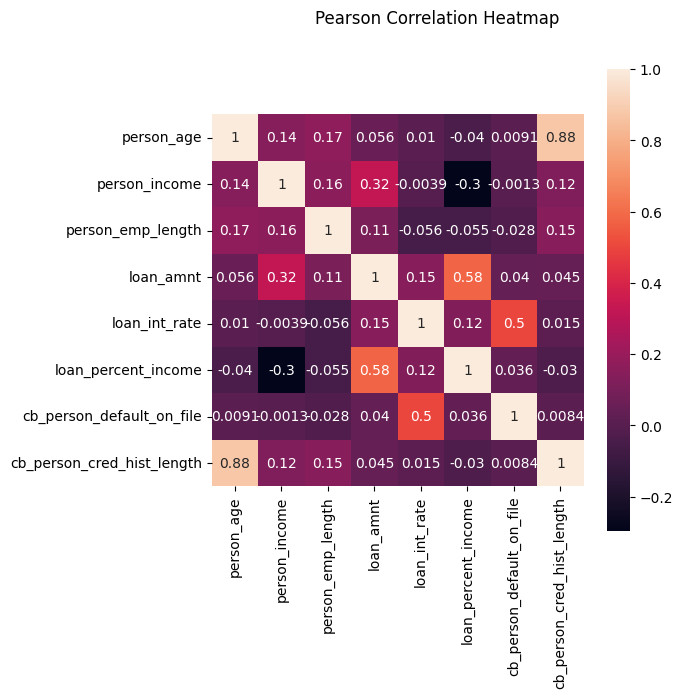

In [39]:
# check for correlation among the features
plt.figure(figsize=(6,6))

sns.heatmap(conti_df.drop(['loan_status'],axis=1).corr(), square=True, annot=True,)
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

In [40]:
ff = conti_df.drop(['loan_status'],axis=1).corr()
ff

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
person_age,1.000000,0.141363,0.168997,0.055849,0.010372,-0.039566,0.009111,0.877578
person_income,0.141363,1.000000,0.158595,0.324745,-0.003893,-0.297596,-0.001301,0.122739
person_emp_length,0.168997,0.158595,1.000000,0.110850,-0.056440,-0.055080,-0.027854,0.146092
loan_amnt,0.055849,0.324745,0.110850,1.000000,0.145972,0.577362,0.040317,0.045442
loan_int_rate,0.010372,-0.003893,-0.056440,0.145972,1.000000,0.123602,0.500292,0.015313
loan_percent_income,-0.039566,-0.297596,-0.055080,0.577362,0.123602,1.000000,0.036117,-0.029890
cb_person_default_on_file,0.009111,-0.001301,-0.027854,0.040317,0.500292,0.036117,1.000000,0.008439
cb_person_cred_hist_length,0.877578,0.122739,0.146092,0.045442,0.015313,-0.029890,0.008439,1.000000


In [41]:
fig = px.imshow(ff, text_auto=True)
fig.show()

- Person correlation map indicates a high collinearity between the cb_person_cred_hist_length and the person_age. 
- Following the correlation analysis, I am dropping those two features.

In [42]:
# drop a feature 
df=data_df.drop(['cb_person_cred_hist_length', 'person_age'],axis=1)

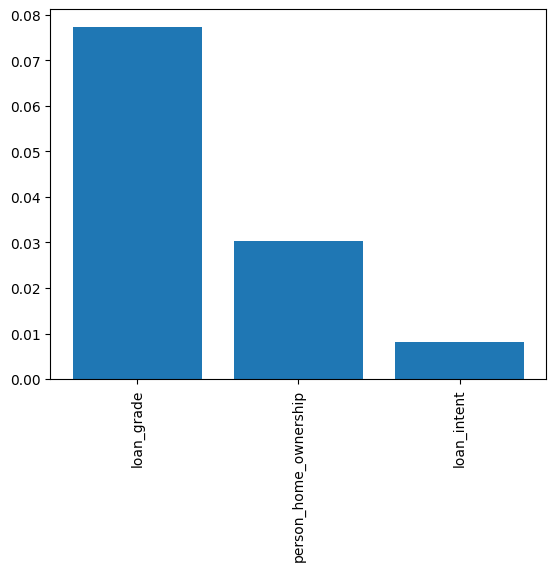

In [43]:
# returns the MI scores
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df.loan_status)

# select categorial variables excluding loan status
cat_vars = df.select_dtypes(include=object)

# compute the MI score between each categorical variable and the target
feature_importance_df = cat_vars.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
plt.bar(feature_importance_df.index, height = feature_importance_df.values)
plt.xticks(rotation=90)
plt.show()

In [44]:
feature_importance_df

loan_grade               0.077334
person_home_ownership    0.030432
loan_intent              0.008204
dtype: float64

Based on the MI scores, loan_intent and person_home_ownership shows very low scores and we can drop them for further analysis.

In [45]:
# select the final set of features
selected_features = df.drop(['loan_intent', 'person_home_ownership'], axis=1)

In [46]:
# Label encoding for loan grade
le = preprocessing.LabelEncoder()
selected_features['loan_grade'] = le.fit_transform(selected_features.loan_grade.values)

In [47]:
selected_features.head()

,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file
0,59000,123.0,3,35000,16.02,1,0.59,1
1,9600,5.0,1,1000,11.14,0,0.10,0
2,9600,1.0,2,5500,12.87,1,0.57,0
3,65500,4.0,2,35000,15.23,1,0.53,0
4,54400,8.0,2,35000,14.27,1,0.55,1


# Model Training

In [48]:
# returns the model performance in terms of accuracy, classification report and the confusion matrix
def model_performance(y_test,y_pred, method):
    
    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")
    
    #generate the classification report
    print(classification_report(y_test,y_pred))
    
    #generate the confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)

In [49]:
# select the features and the target variables
X = selected_features.drop(['loan_status'],axis=1)
y = selected_features['loan_status']

# Train/ Test Split using stratify sampling to solve the class imbalance problem
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=33)

## Random Forest Classifier
Random Forests are an ensemble machine learning algorithm that can be used for both classificaion and regression tasks.

In [50]:
# setting the parameters for the model
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50,max_leaf_nodes = 30)
# fitting the model
model_rf.fit(X_train, y_train)

# make predictions
prediction_test = model_rf.predict(X_test)

Accuracy score of the model 0.8772481229264886
Classification report 

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4486
           1       0.76      0.64      0.69      1241

    accuracy                           0.88      5727
   macro avg       0.83      0.79      0.81      5727
weighted avg       0.87      0.88      0.87      5727



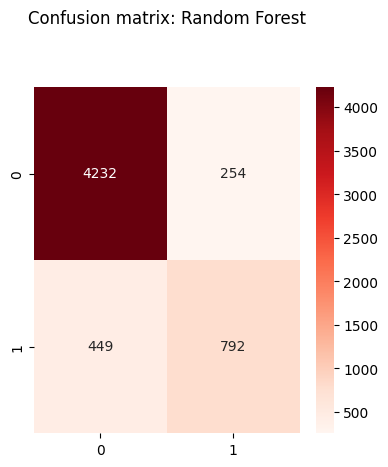

In [51]:
# measure the model performance
model_performance(y_test,prediction_test, 'Random Forest')

- The precision values of 90% and 76% for classes 0 and 1, respectively, signify the model's ability to accurately identify true positive instances within each class. Specifically, for class 0, the model demonstrates high precision (90%), implying that when it predicts a positive instance for this class, it is correct 90% of the time.
---
- On the other hand, the lower precision of 76% for class 1 suggests that the model is somewhat less precise in identifying positive instances for this category. The recall values of 94% for class 0 and 64% for class 1 indicate the model's effectiveness in capturing a significant portion of true positive instances for class 0 but a comparatively lower recall for class 1. 
---
- Overall, the model excels in correctly identifying instances of class 0, but there is room for improvement in its performance for class 1, where it may miss some positive instances. Note that class 0 indicates loan status 0 and class =1 indicates loan status 1.

## Cross validation

In [52]:
from sklearn.model_selection import RepeatedStratifiedKFold
# apply k-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.872 (0.005)


## Model tunning

To optimize the performance of our RandomForest classifier, we can use a grid search approach across its various parameters. By systematically exploring different combinations of hyperparameter values, we can find a configuration that improves the model's predictive capabilities. 

---
This process allows us to fine-tune the RandomForest classifier and achieve an optimal balance in parameter settings, ultimately improving its overall accuracy and robustness.

In [53]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'n_estimators': [200, 500],
    'max_leaf_nodes' : [20, 30]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [54]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 30, 'n_estimators': 500}

In [55]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 30, 'n_estimators': 500}

### Feature Importance Scores

- Random Forests calculate feature importance by evaluating how much each feature contributes to reducing impurity (in classification) or error (in regression) when used as a splitting criterion across the ensemble of decision trees. 
---
Features that consistently lead to purer nodes or lower error are considered more important and are used as the basis for feature selection.

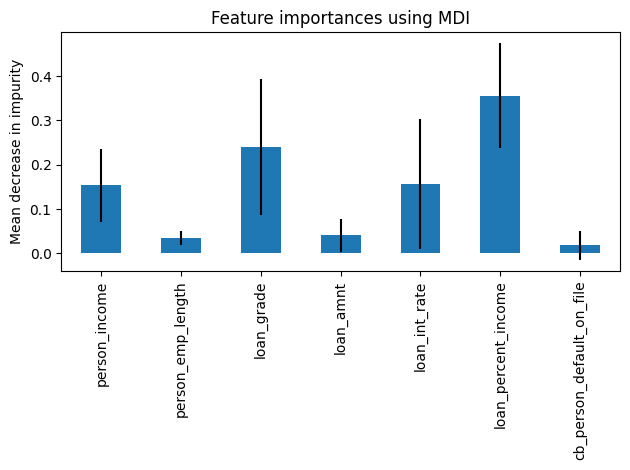

In [56]:
forest_importances = pd.Series(model_rf.feature_importances_, index=X.columns.values)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## XGBoost

In [57]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [58]:
# Convert y to one-dimensional array (vector)
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [59]:
# fit and train the model
model_xgb = XGBClassifier(learning_rate=0.01,
                            n_estimators=50,
                            max_depth=6,
                            random_state=42,
                            n_jobs=-1)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)

Accuracy score of the model 0.8032128514056225
Classification report 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4486
           1       0.97      0.09      0.17      1241

    accuracy                           0.80      5727
   macro avg       0.89      0.55      0.53      5727
weighted avg       0.84      0.80      0.73      5727



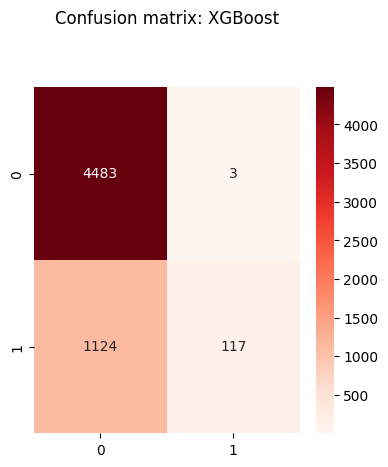

In [60]:
# measure the model performance
model_performance(y_test,y_pred, 'XGBoost')

#### Model tunning (GridSearch)
Next, we can perform hyperparameter tuning using grid search to determine an optimal set of hyperparameters for our XGBoost model. I have only tried two paramaters here for simplicity. But we can define more and values and other parameters.

In [61]:
# grid search for the XGBClassifier
clf = GridSearchCV(
        model_xgb,
        {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200]},
        verbose=1,
        n_jobs=2,
    )
clf.fit(X_train,y_train)
print(clf.best_score_)
print(clf.best_params_)

[CV] END bootstrap=True, max_depth=80, max_leaf_nodes=20, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=80, max_leaf_nodes=30, n_estimators=200; total time=   3.9s
[CV] END bootstrap=True, max_depth=90, max_leaf_nodes=20, n_estimators=200; total time=   4.6s
[CV] END bootstrap=True, max_depth=90, max_leaf_nodes=20, n_estimators=200; total time=   3.3s
[CV] END bootstrap=True, max_depth=90, max_leaf_nodes=20, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=90, max_leaf_nodes=30, n_estimators=200; total time=   3.7s
[CV] END bootstrap=True, max_depth=80, max_leaf_nodes=20, n_estimators=200; total time=   3.5s
[CV] END bootstrap=True, max_depth=80, max_leaf_nodes=20, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=80, max_leaf_nodes=30, n_estimators=500; total time=   8.8s
[CV] END bootstrap=True, max_depth=90, max_leaf_nodes=20, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=90, max_leaf_no

##### K-fold cross validation
XGBoost supports k-fold cross validation using the cv() method. In tthe following, xgb_cv contains train and test auc metrics for each boosting round.

In [62]:
# define data_dmatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X.columns.values))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(X.columns.values))

In [63]:
from xgboost import cv

# setting the parameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# apply cross validation
xgb_cv = cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.624419,0.003112,0.622384,0.006566
1,0.797906,0.003443,0.794819,0.006442
2,0.862019,0.001601,0.859626,0.004062
3,0.870227,0.002174,0.867050,0.004941


In [64]:
# training the model again using the following method to get feature importance with feature names
evals = [(dtrain, 'train'), (dtest, 'validation')]
model_xgb_2 = xgb.train(params, dtrain, num_boost_round=60, 
                  early_stopping_rounds=50, maximize=False, evals=evals, verbose_eval=10)

[0]	train-logloss:0.52041	validation-logloss:0.52007
[10]	train-logloss:0.42983	validation-logloss:0.42595
[20]	train-logloss:0.37018	validation-logloss:0.36409
[30]	train-logloss:0.34872	validation-logloss:0.34206
[40]	train-logloss:0.33375	validation-logloss:0.32727
[50]	train-logloss:0.32656	validation-logloss:0.32052
[59]	train-logloss:0.32181	validation-logloss:0.31601


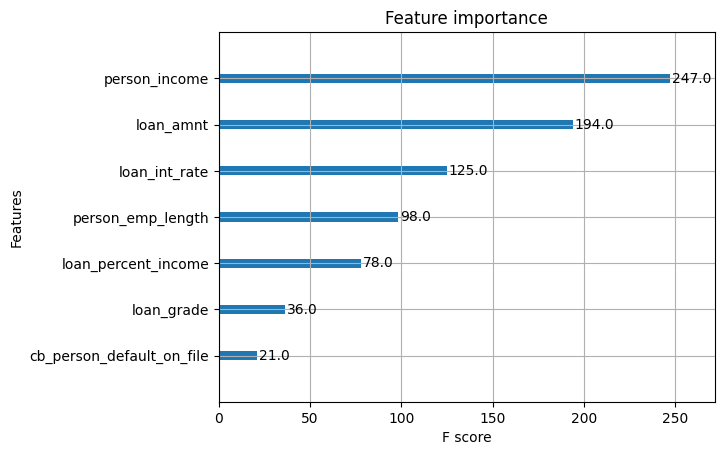

In [65]:
# plot the fearures according to their importance
xgb.plot_importance(model_xgb_2)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

import plotly.graph_objects as go

- Assuming you have feature names in a list called 'feature_names'
- and feature importances in a list called 'importance_values'
- obtained from your XGBoost model (model_xgb_2 in your case)

- Create a trace for the bar chart
trace = go.Bar(
    x=feature_names,
    y=importance_values,
    name='Feature Importance',
    marker=dict(color='royalblue'),
)

- Configure the layout
layout = go.Layout(
    title='Feature Importance for XGBoost Model',
    xaxis_title='Features',
    yaxis_title='Importance Score',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    margin=dict(l=20, r=20, t=50, b=20)
)

- Create the figure
fig = go.Figure(data=[trace], layout=layout)

- Display the plotly figure
fig.show()


Here we found out, 2 most important feature for out analysis is,
- Person Income 
- Loan Amount

This study found that Random Forest and XGBoost performed similarly. 
Interestingly, the **XGBoost** model's feature importance analysis aligned with **financial principles**, suggesting "person_income" and "loan_int_rate" are crucial factors. 
---
Future research could leverage this insight for feature selection and potentially improve model performance.